In [1]:
# Import packages
%reset -f
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy 
from helpers import sigmoid_derivative, gradient_update, plot_loss, prep_data, get_best_results
import numpy as np
import cv2

In [2]:
def initialize(X, h1, h2): 
    '''
    --------------------
    Parameter Initialization
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X [n = 12000])
    --------------------
    Output: 
    weights: Weight terms initialized as random normals
    biases: Bias terms initialized to zero
    --------------------
    '''
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(h2, h1)
    
    dim3 = 1/np.sqrt(W2.shape[1])
    W3 = dim3 * np.random.randn(1, h2)

    b1 = np.zeros((h1, 1))
    b2 = np.zeros((h2, 1))
    b3 = np.zeros((1, 1))
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

In [3]:
def forward_pass(X, weights, biases):
    '''
    ----------------------------------
    Forward propogation:
    Send inputs through the network to
    generate output
    ----------------------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    weights: Binary (1/0) training label (shape = n X 1)
    biases:
    --------------------
    Output: 
    activations: vector of results from passing
    inputs through each neuron
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    
    z3 = W3 @ a2 + b3
    a3 = sigmoid(z3)
    
    activations = (z1, a1, z2, a2, z3, a3)
    
    return activations

In [4]:
def backpropagation(X, y, weights, biases, activations):
    '''
    --------------------
    Backpropagation
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    y: Binary (1/0) training label (shape = n X 1)
    weights: Current set of weights
    biases: Current set of biases
    activations: Current set of activations
    --------------------
    Output: 
    Derivatives required
    for optimization update
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    z1, a1, z2, a2, z3, a3 = activations
    m = max(y.shape)
    # print(m)
    
    dz3 = (a3 - y)/m
    # print("dz3", dz3.shape)
    
    dW3 = np.dot(dz3, a2.T)
    # print("dW3", dW3.shape)
    
    db3 = np.sum(dz3, axis=1).reshape(-1, 1)
    # print("db3", db3.shape)
    
    da2 = np.dot(W3.T, dz3)
    # print("da2", da2.shape)
    
    dz2 = da2 * sigmoid_derivative(z2)
    # print("dz2", dz2.shape)
    
    dW2 = np.dot(dz2, a1.T)
    # print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)
    # print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    # print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    # print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)
    # print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)
    # print("db1", db1.shape)
    
    return db1, dW1, db2, dW2, db3, dW3

In [5]:
def update_parameters(weights, biases, gradients, learning_rate):
    '''
    --------------------
    Update parameters
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    db1, dW1, db2, dW2, db3, dW3 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
    W3 = gradient_update(W3, learning_rate, dW3)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    b3 = gradient_update(b3, learning_rate, db3)
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

In [6]:
def finite_differences(example, truth, weights, biases, delta_h=1e-9):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    I, J = W3.shape # Change here
    
    deltaW = np.zeros((I, J))
    
    activations = forward_pass(example, weights, biases)
    db1, dW1, db2, dW2, db3, dW3 = backpropagation(example, truth, weights, biases, activations)
    
    for i in range(I):
        for j in range(J):
    
            W_plus = np.copy(W3) # Change here
            W_minus = np.copy(W3) # Change here
            
            W_plus[i][j] += delta_h
            W_minus[i][j] -= delta_h
            
            weights_plus = [W1, W2, W_plus] # Change here
            weights_minus = [W1, W2, W_minus] # Change here
            
            activations_plus = forward_pass(example, weights_plus, biases)
            activations_minus = forward_pass(example, weights_minus, biases)

            loss_plus = get_log_loss(truth, activations_plus[-1])
            loss_minus =  get_log_loss(truth, activations_minus[-1])

            deltaW[i][j] = (loss_plus - loss_minus)/(2 * delta_h)

    difference = np.linalg.norm(dW3 - deltaW) # Change here
    
    return dW3, deltaW, difference, activations_plus[-1], activations_minus[-1] # Change here

In [7]:
def run_finite_differences(X_train_flattened, y_train, w, b, idx=10):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    dW, deltaW, difference, activations_plus, activations_minus = finite_differences(X_train_flattened[:, idx].reshape(-1, 1), 
                                                                  y_train[:, idx].reshape(-1, 1), w, b)
    
    print("dW", dW)
    print("deltaW", deltaW)
    print("difference", difference)
    print(activations_plus, activations_minus)
    
    return(dW, deltaW, difference, activations_plus, activations_minus)

In [8]:
def train(X, y, w, b, h1, h2, lr, epochs, tolerance=1e-1):    
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Initialize history dictionary
    history = {
        "weights": [w],
        "losses": [], 
        "biases": [b],
        "accuracies": []
    }
    
    convergence_counter = 0
    best_loss = np.inf
    
    # Do this for the specified epochs
    for epoch in range(epochs):
        
        # Get weights and bias
        w = history['weights'][epoch]
        b = history['biases'][epoch]
        
        # Forward pass to get activations
        activations = forward_pass(X, w, b)
        
        # Backward pass to get gradients
        gradients = backpropagation(X, y, w, b, activations)
        
        # Gradient descent update
        w, b = update_parameters(w, b, gradients, lr)
    
        # Get last layer output
        y_prob = activations[-1]
        
        # Threshold
        y_pred = np.where(y_prob > 0.5, 1, 0)
    
        # Get loss and accuracy results
        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)
        
        # Check convergence, keeps a counter of how many epochs it has been without an improvement
        # Counter resets whenever there's an improvent            
        if loss < best_loss - tolerance:
            best_loss = loss
            convergence_counter = 0
        else:
            convergence_counter += 1

        # Append results to history
        history["losses"].append(loss)
        history["biases"].append(b)
        history["weights"].append(w)
        history["accuracies"].append(accuracy)
        
        # 10 epochs without an improvment is considered to have converged
        if convergence_counter == 10:
            break
        
        # Display loss for monitoring
        print(loss)
        
        # Stop training if numerical loss underflows
        if np.isnan(loss): break
        
        # Store loss for next epoch
        previous_accuracy = accuracy
    
    # Return statement
    return(history)

In [9]:
def get_results(X_dev, y_dev, history, best_epoch, label="dev"):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    w = history["weights"][best_epoch]
    b = history["biases"][best_epoch]
    activations = forward_pass(X_dev, w, b)

    y_dev_prob = activations[-1]
    y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)

    loss = get_log_loss(y_dev, y_dev_prob)
    accuracy = get_accuracy(y_dev, y_dev_pred)
    print(f"{label} set accuracy: {accuracy}")
    
    return(accuracy)

In [10]:
def execute_pipeline(data_path, idx, h1, h2, lr, epochs):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Set seed for reproducible results
    np.random.seed(1252908)

    # Get data
    X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test = prep_data(data_path)

    # Initialize weights
    weights, biases = initialize(X_train_flattened, h1, h2)
    
    # Check finite difference
    dW, deltaW, difference, activations_plus, activations_minus = run_finite_differences(X_train_flattened, y_train, weights, biases, idx=10)
    
    # Now enter training loop
    training_history = train(X_train_flattened, y_train, weights, biases, h1, h2, lr, epochs)
    
    # Display plots to monitor whether loss functions are correct shape
    plot_loss("loss.png", training_history["losses"][:-2])
    
    # Plot accuracy
    plot_loss("accuracy.png", training_history["accuracies"][:-2], label='Training Accuracy')
    
    # Get weights and biases from best training epoch
    best_training_epoch, best_training_accuracy, best_training_loss = get_best_results(training_history)
    
    # Get dev results
    get_results(X_dev_flattened, y_dev, training_history, best_training_epoch)
    
    # Get test results
    get_results(X_test_flattened, y_test, training_history, best_training_epoch, label="test")
    
    return 

In [11]:
# Set path to data
data_path = '../setup/data'

In [12]:
# Set no. of observations to use for checking finite differences
idx = 10

In [13]:
# Set perceptron parameters: architecture, learning rate, and no. of training epochs
h1 = 8
h2 = 4
lr = 0.1
epochs = 1000

dW [[-0.18303023 -0.17351476 -0.17373708 -0.1751518 ]]
deltaW [[-0.1830302  -0.17351479 -0.17373697 -0.1751517 ]]
difference 1.558757383345652e-07
[[0.64527729]] [[0.64527729]]
8856.98510033028
8804.025224598206
8756.259330743445
8713.189539991632
8674.362979977468
8639.368290840051
8607.832282727755
8579.416765249127
8553.81556174796
8530.751715035882
8509.974886243115
8491.258944588493
8474.39974296122
8459.213072094506
8445.532784652509
8433.209079621134
8422.10693687984
8412.104691643206
8403.092738519073
8394.972355171076
8387.654635945051
8381.059526279885
8375.114949240951
8369.756016063284
8364.924313152345
8360.567258548535
8356.637521406701
8353.092498566457
8349.89384278809
8347.00703769924
8344.4010149374
8342.04780938249
8339.922248751976
8338.001674179652
8336.265688718722
8334.695931002567
8333.275871563286
8331.990629551085
8330.82680781839
8329.772344532652
8328.816379663283
8327.949134852144
8327.16180532537
8326.446462638078
8325.795967164477
8325.20388935462
8324.66

8239.956607884413
8239.276624588176
8238.590097147211
8237.896952627161
8237.197117229993
8236.490516284264
8235.777074235319
8235.056714635339
8234.329360133315
8233.594932464906
8232.85335244217
8232.104539943208
8231.348413901687
8230.584892296249
8229.813892139788
8229.03532946864
8228.249119331633
8227.455175779025
8226.653411851312
8225.843739567918
8225.026069915766
8224.200312837711
8223.366377220847
8222.524170884695
8221.67360056924
8220.81457192286
8219.946989490098
8219.070756699308
8218.185775850177
8217.291948101083
8216.389173456324
8215.477350753223
8214.556377649065
8213.62615060791
8212.686564887244
8211.73751452451
8210.778892323462
8209.810589840406
8208.832497370257
8207.844503932483
8206.84649725687
8205.83836376917
8204.819988576557
8203.79125545298
8202.75204682433
8201.702243753476
8200.641725925148
8199.570371630669
8198.48805775254
8197.394659748876
8196.290051637694
8195.174105981063
8194.046693869099
8192.907684903823
8191.756947182878
8190.594347283104
818

4527.771788701733
4511.796762381841
4495.869754822212
4479.991565278324
4464.162973200335
4448.384738241486
4432.657600283666
4416.982279479365
4401.359476309318
4385.7898716550935
4370.274126885923
4354.812883959025
4339.406765532763
4324.05637509189
4308.762297084244
4293.525097068183
4278.345321870128
4263.223499751561
4248.160140584858
4233.1557360373445
4218.210759762982
4203.325667601122
4188.5008977817615
4173.73687113677
4159.033991316577
4144.392645011818
4129.813202179462
4115.296016272961
4100.841424475999
4086.4497479393835
4072.121292020734
4057.8563465265297
4043.6551859561896
4029.5180697478286
4015.445242525351
4001.436934346588
3987.493360952173
3973.614724014878
3959.8012113891464
3946.0529973605867
3932.3702428951747
3918.7530958879597
3905.201691411069
3891.716151960807
3878.296587703687
3864.9430967212056
3851.6557652532338
3838.434667939843
3825.279868061469
3812.191417777259
3799.169358361506
3786.213720438055
3773.3245242125886
3760.5017797027017
3747.7454869656

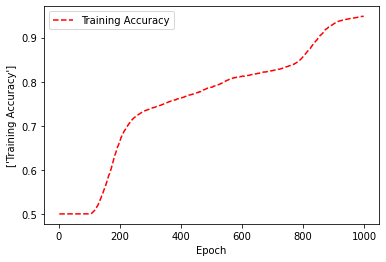

In [14]:
# Execute pipeline
execute_pipeline(data_path, idx, h1, h2, lr, epochs)